In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
from utils2 import binary_search
import time
import sys
import os

# Simulating graphene quantum dots

I will start by making graphene quantum dots with different shapes. The most interesting shapes for our sake are:

1. **Circular**
2. **Hexagonal**
3. **Triangular**
4. **Nanoribbons**

Nanoribbons do not really classify as quantum dots, but they have nice topological properties that could be useful.

The functions `create_graphene_hexagonal_system`, `create_graphene_tiangular_system` and `create_graphene_circular_system` will create graphene quantum dots of the specified shapes, the first two functions have a `start` parameter which is a starting angle and `type_` which specifies the edge types (zigzag or armchair), with the default being armchair. `param` parameter is an object where the miscellaneous parameters of the model are stored, such as (nnn) interaction coefficient `t_prime` and the magnetic field strength (normalized with the flux quanta $\hbar/e$) `B`.

In [23]:
# define pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

lat = kwant.lattice.honeycomb(a = 1.0, norbs=2)
# lat = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],  # lattice vectors
#                       [[0, 0], [0, 1/np.sqrt(3)]], norbs=2)  # Coordinates of the sites
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onsite(site, param):
    x, y = site.pos
    if np.random.rand() < param.p:
        return param.U_imp*sigma_0 + param.m*sigma_0 if site.family == a_lat else param.U_imp*sigma_0-param.m*sigma_0
    else:
        return param.m*sigma_0 if site.family == a_lat else -param.m*sigma_0
def nn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return -np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))*sigma_0
def nnn_hopping(site1, site2, param):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return (param.t2*sigma_0 + 1j*param.t_prime*sigma_z)*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))


def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_hexagonal_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 6, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            else: y += 1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onste # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_tiangular_system(r, start = 0, a = 1.0, norb = 2, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside

    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onsite # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site
    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    
    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping
    # sys[a_lat.neighbors(1)] = nnn_hopping
    # sys[b_lat.neighbors(1)] = lambda site1, site2, param: -1*nnn_hopping(site1, site2, param)
    
    return sys

def create_graphene_circular_system(r, a=1.0, norb=2):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    
    sys = kwant.Builder()
    sys[lat.shape(lambda pos: np.linalg.norm(np.array([*pos])) < r, (0, 0))] = onsite
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    # sys[lat.neighbors(n=2)] = nnn_hopping
    sys[lat_neighbors_2] = nnn_hopping

    return sys

def create_graphene_nanoribbon(width, length, a=1.0, norb=1):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    sys = kwant.Builder()
    sys[lat.shape(lambda pos: abs(pos[1]) < width and abs(pos[0])<length, (0, 0))] = onsite
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sys[lat_neighbors_2] = nnn_hopping
    # sys[lat.neighbors(n=2)] = nnn_hopping
    # attach leads
    sym = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym)
    lead[lat.shape(lambda pos: abs(pos[1]) < width, (0, 0))] = onsite
    lead[lat.neighbors(n=1)] = nn_hopping
    # lead[lat.neighbors(n=2)] = nnn_hopping
    lead[lat_neighbors_2] = nnn_hopping
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    return sys

The Hamiltonian class is meant to ease dealing with the hamiltonians, getting eigenvalues, and plotting them, `.sol()` should be called to get the eigenvalues and/or vectors

In [24]:
class Hamiltonian:
    def __init__(self, h, norb=1, N=None):
        self.h = h
        if N is None: self.N = h.shape[0]
        else: self.N = N
        self.n_sites = h.shape[0]//norb
        self.sol = None
        self.energies = None
        self.eigenstates = None
        self.norb=norb
    
    def solve(self, k=None, return_eigenvectors=True):
        
        if k is None: k = self.N-2*self.norb
        self.k = k
        self._returned_eigenvectors = return_eigenvectors
        if return_eigenvectors is False:
            self.sol =  [sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)]
        else:
            self.sol =  sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)
    
    def get_eigenvalues(self):
        if self.sol is None: self.solve(return_eigenvectors=False)
        self.eigenenergies_preorb = np.sort(self.sol[0])
        if self.norb > 1:
            self.eigenenergies = np.zeros((self.k//self.norb, self.norb))
            for orb in range(self.norb):
                self.eigenenergies[:, orb] = self.eigenenergies_preorb[orb::self.norb]
        else: self.eigenenergies = self.eigenenergies_preorb
        return self.eigenenergies
    
    def get_eigenstates(self):
        if self._returned_eigenvectors is False: self.solve(return_eigenvectors=True)
        self.eigenstates_preorb = (self.sol[1].T)[np.argsort(self.sol[0])]
        if self.norb > 1:    
            # self.eigenstates = np.zeros((self.k, self.n_sites, self.norb), dtype=complex)
            self.eigenstates = np.zeros((self.k//self.norb, self.n_sites, self.norb), dtype=complex)
            for orb in range(self.norb):
                self.eigenstates[:, :, orb] = self.eigenstates_preorb[::self.norb, orb::self.norb]
        else:
            self.eigenstates = self.eigenstates_preorb
        return self.eigenstates
    
    def get_eigenstate(self, i, orb=None):
        if self.eigenstates is None: self.get_eigenstates()
        if orb is None: return self.eigenstates[i]
        elif orb > self.norb: raise ValueError("orbital index out of range")
        return self.eigenstates[i, :, orb-1]
    
    def zero_energy(self):
        if self.eigenenergies is None: self.get_eigenvalues()
        return np.where(np.allclose(np.abs(self.eigenenergies), 0, rtol=1e-2))[0]
    
    def plot_state(self, system, i):
        if self.eigenstates is None: self.get_eigenstates()
        kwant.plotter.map(sys=system, value=self.eigenstates[i], oversampling=10, cmap='inferno', show=True, dpi=400)
        plt.show()


In [25]:
# calculate the current
def calculate_current(sys, state, param, plot=False, polarized = False, up = None):
    if polarized is True:
        currentz = kwant.operator.Current(sys, sigma_z)
        current0 = kwant.operator.Current(sys, sigma_0)
        if up is None:
            i = currentz(state, params=dict(param = param))
        elif up is True:
            i = (current0(state, params=dict(param = param)) + currentz(state, params=dict(param = param)))/2
        else:
            i = (current0(state, params=dict(param = param)) - currentz(state, params=dict(param = param)))/2
    else: 
        current = kwant.operator.Current(sys, sigma_0)
        i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

def calculate_current_2(sys, state_number, param, plot=False, polarized = False, up = None):
    # h = sys.hamiltonian_submatrix(params=dict(param = SimpleNamespace(B=0.0, t_prime=0.05, m=0.0)), sparse=True)
    h = sys.hamiltonian_submatrix(params=dict(param = param), sparse=True)
    N = h.shape[0]
    hamiltonian = Hamiltonian(h, norb=2)
    hamiltonian.solve(return_eigenvectors=True)
    energies = hamiltonian.get_eigenvalues()

    state1 = hamiltonian.get_eigenstate(state_number, orb=1)
    state2 = hamiltonian.get_eigenstate(state_number, orb=2)

    state = np.zeros(N)*0.0j
    state[0::2] = state1
    state[1::2] = state2
    
    if polarized is True:
        currentz = kwant.operator.Current(sys, sigma_z)
        current0 = kwant.operator.Current(sys, sigma_0)
        if up is None:
            i = currentz(state, params=dict(param = param))
        elif up is True:
            i = (current0(state, params=dict(param = param)) + currentz(state, params=dict(param = param)))/2
        else:
            i = (current0(state, params=dict(param = param)) - currentz(state, params=dict(param = param)))/2
    else: 
        current = kwant.operator.Current(sys, sigma_0)
        i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

## Triangular Isolated dots

In [26]:
triangular_predot = create_graphene_tiangular_system(10, np.pi/2, 1.0, 2, 'zigzag')

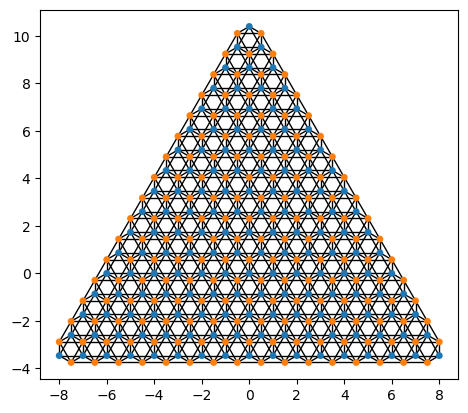

In [27]:
kwant.plot(triangular_predot)
plt.show()

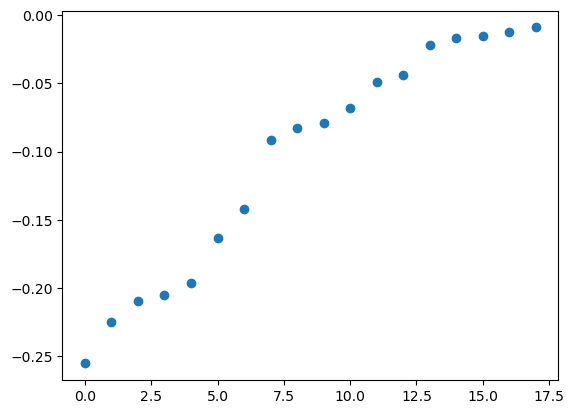

In [28]:
triangular_dot = triangular_predot.finalized()
par_dict = dict(param = SimpleNamespace(B=1.3, t_prime=0.1, t2=0.075, m=0.0, U_imp=0.0, p=0.0))
h = triangular_dot.hamiltonian_submatrix(params=par_dict, sparse=False)
eig_vals, eig_states = np.linalg.eigh(h)
eig_states= eig_states.T
plt.plot(eig_vals[315:333], 'o')

In [32]:
triangular_dot = triangular_predot.finalized()
h = triangular_dot.hamiltonian_submatrix(params=dict(param = SimpleNamespace(B=0.0, t_prime=0.13, t2=0.0, m=0.0, U_imp=0.05, p=0.0)), sparse=True)
N = h.shape[0]

In [33]:
hamiltonian = Hamiltonian(h, norb=2)
hamiltonian.solve(return_eigenvectors=True)
energies = hamiltonian.get_eigenvalues()

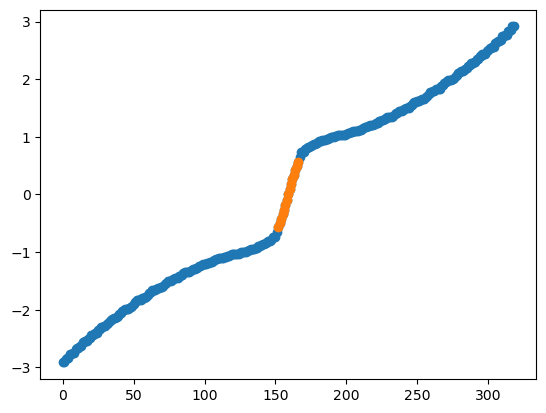

In [34]:
plt.scatter(range(len(energies)), energies[:, 0])
ind_i = 152
ind_f = 167
plt.scatter(list(range(len(energies)))[ind_i: ind_f], energies[ind_i: ind_f, 0])
plt.show()

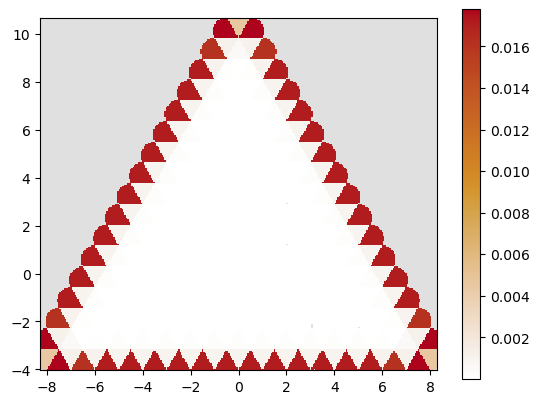

In [35]:
state = hamiltonian.get_eigenstate(160, orb=2)

kwant.plotter.map(triangular_dot, np.abs(state)**2, oversampling=10)
plt.show()

In [36]:
state1 = hamiltonian.get_eigenstate(160, orb=1)
state2 = hamiltonian.get_eigenstate(160, orb=2)

In [37]:
current_plot_state = np.zeros([len(state1)+ len(state2)])*0.0j
current_plot_state[::2] = state1
current_plot_state[1::2] = state2

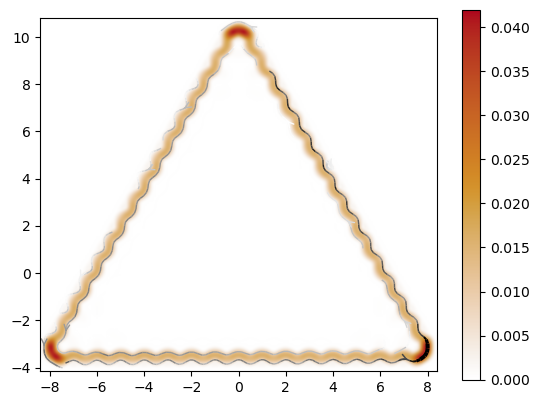

array([ 1.56336692e-02, -1.56336692e-02, -1.96500051e-04, ...,
        6.85243849e-06,  1.54879380e-03,  1.44527158e-03])

In [48]:
calculate_current(triangular_dot, current_plot_state, SimpleNamespace(B=0.0, t_prime=-0.05, t2=0.0), plot=True, polarized=False, up=False)

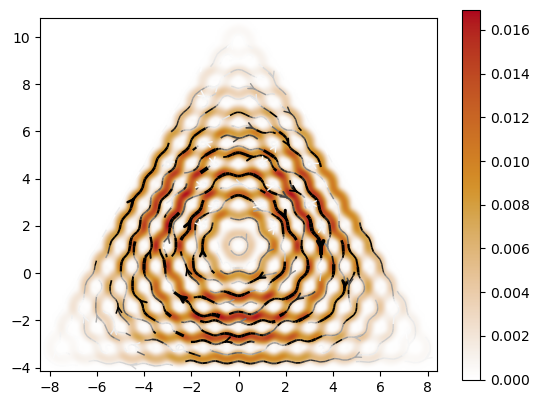

array([-2.87541784e-04,  2.87541784e-04, -2.83932252e-06, ...,
        4.73713593e-06,  4.48455332e-05,  4.32325098e-05])

In [22]:
calculate_current_2(triangular_dot, 334//2, SimpleNamespace(B=0.0, t_prime=0.05, m=0.0, U_imp=0.05, p=0.0, t2=0.0), plot=True, polarized=True)

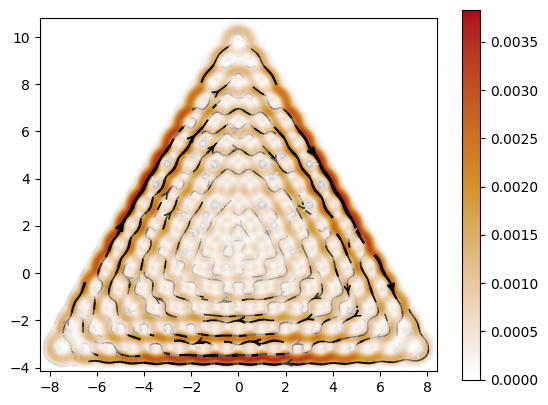

array([-5.89651591e-04,  5.89651591e-04, -3.32004984e-06, ...,
        5.04367106e-06,  1.35621800e-04,  1.34120330e-04])

In [27]:
calculate_current_2(triangular_dot, 333//2, SimpleNamespace(B=0.0, t_prime=0.05, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

Now we are done with the existance of edge states $ \color{red} \text{remember to add the reproduction of results and the "semi-analytic" arguments for the existance of edge states}\color{black} $
We will now try to see what might preserve these edge states

From here on we have two goals:

1. **Try to find the conditions under which graphene dots will act as a topological insulators**
2. **Optimize the size of the dot, while maintaining protected topological edge states**

To achieve this we first have shown that such edge states exist, now we need to monitor how they change with given fields.

We saw that the edge states will not necesserly be **exacty zero energy** states, yet they have to be around the zero energy for the edges to be better localized, non-zero energy will increase the depth of the edge.

While we notice a "somewhat clear" difference in the expected position as we move from (perturbed 0 energy states) to higher energies, which hints at the possibility to find such edge states, we are still not sure what can further distinguish and charectrize those states.

I will make few guesses as what to do:

1. The energies will sort of linearize with the spin-orbit coupling, we know that spin orbit coupling is necessery to realize spin quantum hall effect, however it seems to introduce a problem with the energies.
2. The size of the dot might have something to do with it. As the topological edge states are bulk properties


So what do I know:
1. We have edge states in the graphene zig-zag quantum dots.
2. The spin orbit coupling while it removed the edge states degeneracy, it kept the edge states

The second point is a bit tricky, since as we approach the extremes of the proto-zero-energy states, we further delocalize the edge states. While I still believe there is a fundemental difference between the "proto-zero energy edge states" and the rest of the bulk states, I am still skeptical as whether spin-orbit coupling is working with or against us

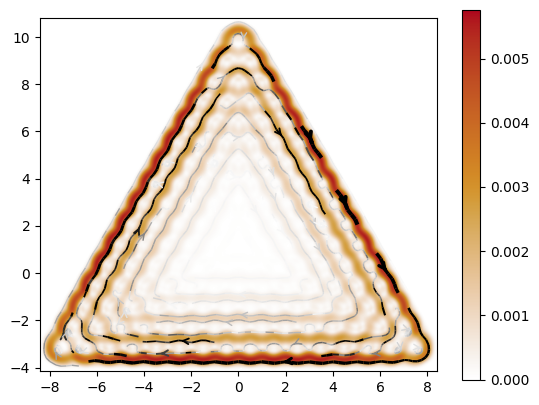

array([-1.68242152e-03,  1.68242152e-03, -9.17194537e-06, ...,
        1.14866560e-05,  3.95724091e-04,  3.91503869e-04])

In [38]:
calculate_current_2(triangular_dot, 165, SimpleNamespace(B=0.0, t_prime=0.05, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

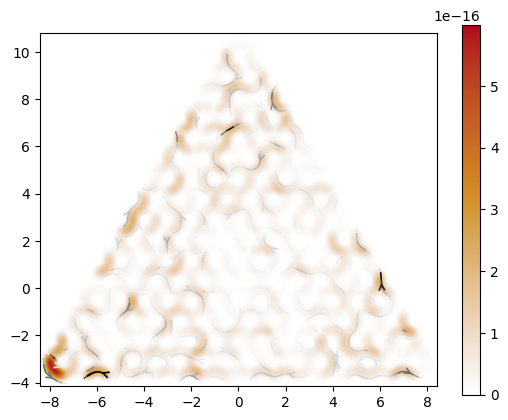

array([ 2.40844712e-16, -2.40844712e-16,  0.00000000e+00, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [39]:
calculate_current_2(triangular_dot, 165, SimpleNamespace(B=0.0, t_prime=0.0, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

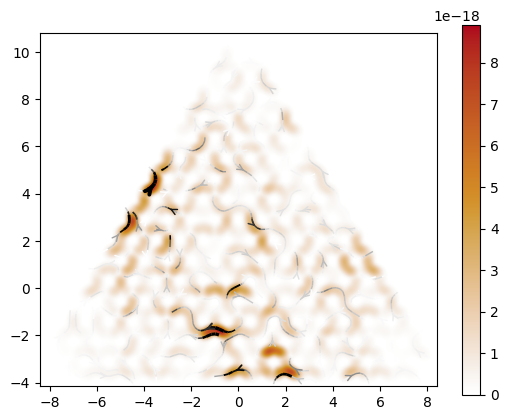

array([ 4.8646274e-21, -4.8646274e-21,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00])

In [41]:
calculate_current_2(triangular_dot, 160, SimpleNamespace(B=0.0, t_prime=0.0, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

It is clear that in the absense of SO coupling there is not current carrying edge state to speak of.

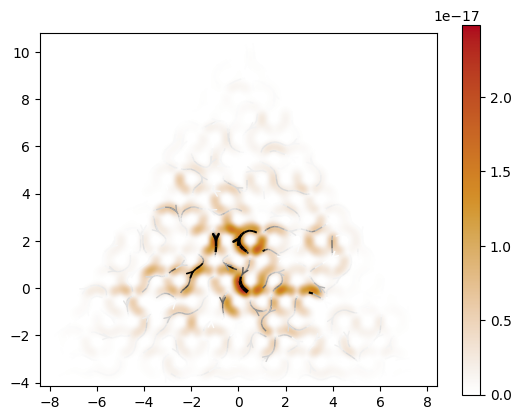

array([-6.90548041e-22,  6.90548041e-22,  0.00000000e+00, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [42]:
calculate_current_2(triangular_dot, 160, SimpleNamespace(B=10.0, t_prime=0.0, m=0, U_imp=0.05, p=0.0), plot=True, polarized=True)

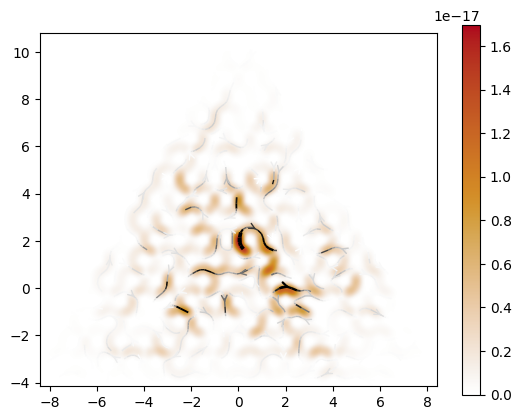

array([ 1.46012643e-22, -1.46012643e-22,  0.00000000e+00, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [43]:
calculate_current_2(triangular_dot, 160, SimpleNamespace(B=10.0, t_prime=0.0, m=0, U_imp=0.05, p=0.0), plot=True, polarized=False)

Not even plain magnetic fields made a difference (which is expected as there is no current source here).
Therefore, for now it seems our best hope is the spin-orbit coupling

### **To do: Calculate the energy eigenstates for higher coupling constants**

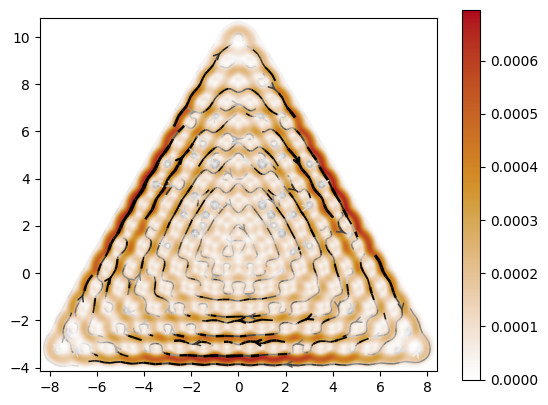

array([-9.37827979e-05,  9.37827979e-05, -2.07732351e-08, ...,
        3.38206409e-08,  2.22305175e-05,  2.22195253e-05])

In [45]:
calculate_current_2(triangular_dot, 166, SimpleNamespace(B=0.0, t_prime=0.01, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

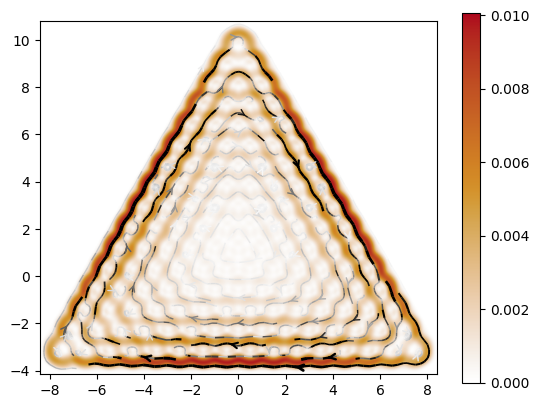

array([-2.36023009e-03,  2.36023009e-03, -5.53962564e-05, ...,
        6.67832647e-05,  4.91693136e-04,  4.79421633e-04])

In [46]:
calculate_current_2(triangular_dot, 333//2, SimpleNamespace(B=0.0, t_prime=0.1, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

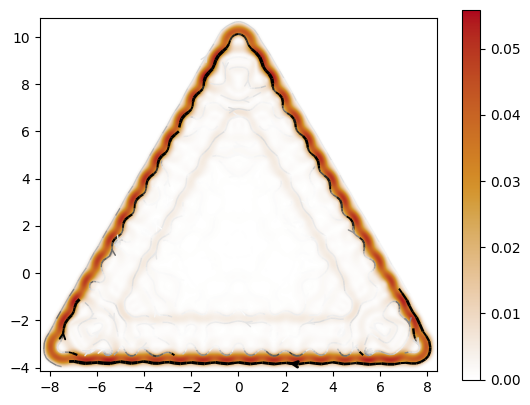

array([-1.73435989e-02,  1.73435989e-02, -7.15042935e-05, ...,
        6.90240930e-04, -7.46116941e-04,  7.56185331e-03])

In [47]:
calculate_current_2(triangular_dot, 166, SimpleNamespace(B=0.0, t_prime=0.5, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

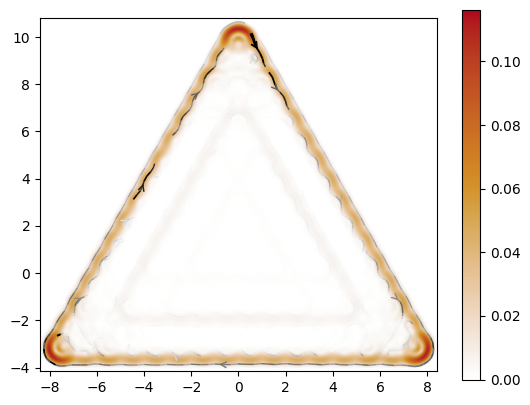

array([-0.06780203,  0.06780203, -0.01788168, ..., -0.00010156,
        0.0268276 ,  0.01198721])

In [49]:
calculate_current_2(triangular_dot, 160, SimpleNamespace(B=0.0, t_prime=0.5, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

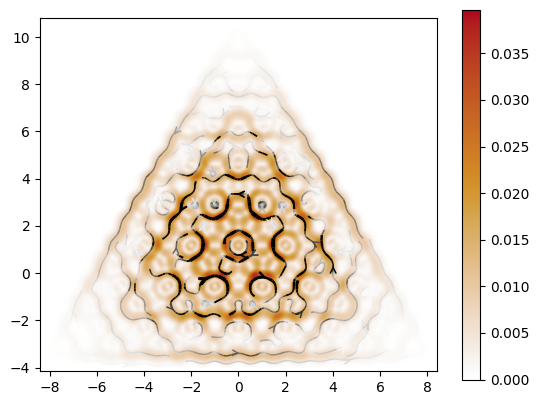

array([ 1.72594356e-05, -1.72594356e-05, -1.49482496e-04, ...,
        2.11226958e-05, -3.61354028e-06,  2.59045477e-05])

In [50]:
calculate_current_2(triangular_dot, 167, SimpleNamespace(B=0.0, t_prime=0.5, m=0.0, U_imp=0.05, p=0.0), plot=True, polarized=True)

It seems that the higher the SO coupling the better the distinguish between edge states and bulk states is

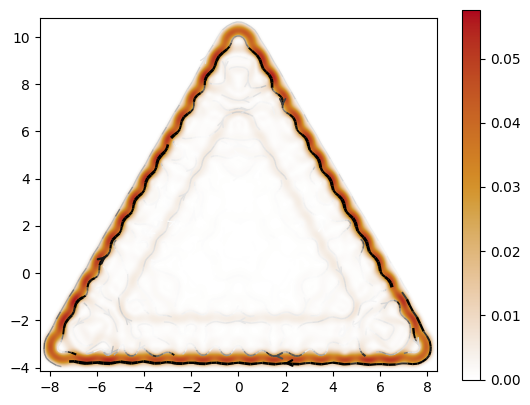

array([-0.01860528,  0.0176722 , -0.0003076 , ...,  0.0006491 ,
       -0.00086756,  0.00720512])

In [61]:
calculate_current_2(triangular_dot, 166, SimpleNamespace(B=0.0, t_prime=0.5, m=0.0, U_imp=0.05, p=0.3), plot=True, polarized=True)

## Nanoribbons

Now I will check the edge states on nanoribbons, I will treat them as dots attached to a lead first (So infinite system)

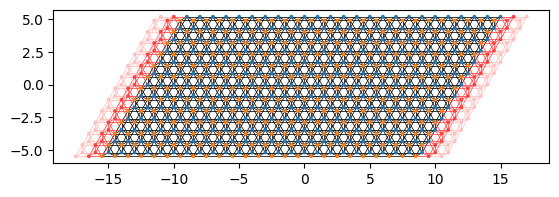

In [77]:
# create a nanoribbon
ribbon = create_graphene_nanoribbon(5.5, 10, 1.0, 2)
kwant.plot(ribbon)
plt.show()
ribbon = ribbon.finalized()

In [78]:
len(ribbon.sites)

650

In [119]:
# ribbon_parameters = SimpleNamespace(B=0., t_prime=0.1, m=0.09742275)
ribbon_parameters = SimpleNamespace(B=0.1, t_prime=0.0, m=0.0)

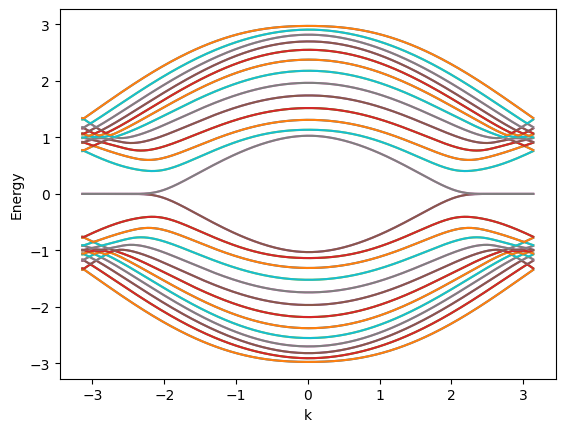

In [120]:
kwant.plotter.bands(ribbon.leads[0], params=dict(param=ribbon_parameters), show=True, momenta=np.linspace(-np.pi, np.pi, 256))
plt.show()

We notice three three sets of separated bands, we further notice that the band gap closes at the edge, while it is "almost impossible" to close the gap at the edges (while maintaing conductivity that is). We will try to maximize the gap in the bulk ($k$ away from the edges)

In [121]:
state_rib = kwant.wave_function(ribbon, energy=0.5, params=dict(param=ribbon_parameters))
state_rib = state_rib(0)
state_rib.shape

(6, 1300)

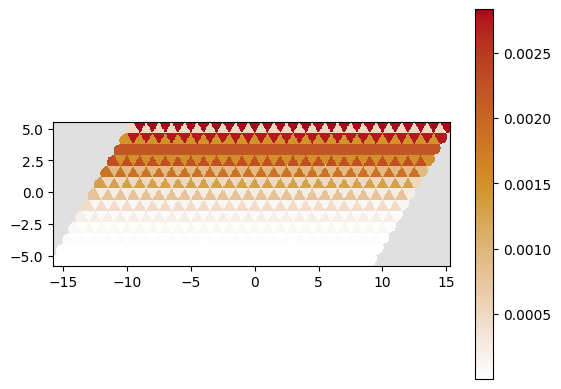

In [124]:
kwant.plotter.map(ribbon, np.abs(state_rib[2][1::2])**2, oversampling=10)
plt.show()

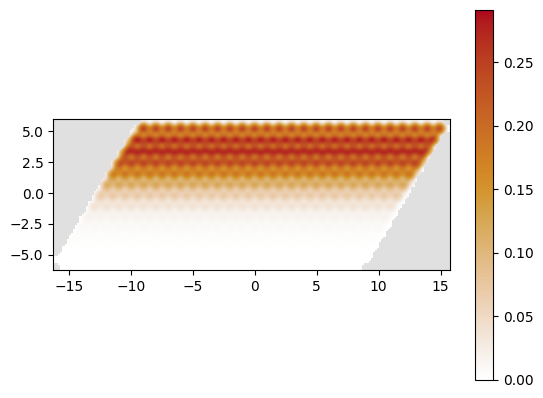

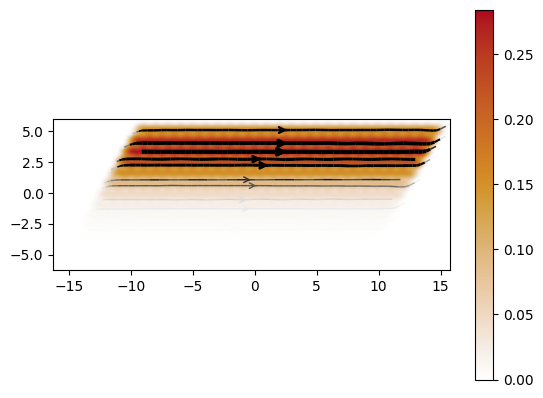

In [127]:
density_rib_op = kwant.operator.Density(ribbon, sigma_0)
current_rib_op = kwant.operator.Current(ribbon, sigma_0)


density_rib = density_rib_op(state_rib[3], params=dict(param=ribbon_parameters))
current_rib = current_rib_op(state_rib[3], params=dict(param=ribbon_parameters))

kwant.plotter.density(ribbon, density_rib)
plt.show()
kwant.plotter.current(ribbon, current_rib)
plt.show()

## Another nanoribbon

In [633]:
nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b
def create_nanoribbon_2(length, width, a=1.0):
    rib = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
    rib[lat.shape((lambda pos: abs(pos[1]) < length/2), (0, 0))] = onstie
    rib[lat.neighbors(1)] = nn_hopping
    rib[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = nnn_hopping
    return rib

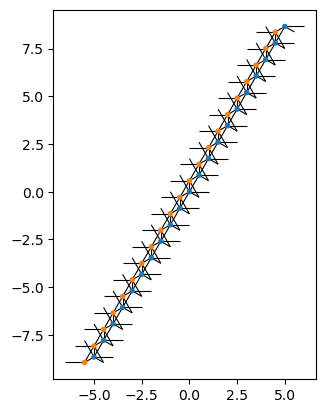

In [638]:
nano_ribbon2 = create_nanoribbon_2(18, 5)
kwant.plot(nano_ribbon2)
plt.show()

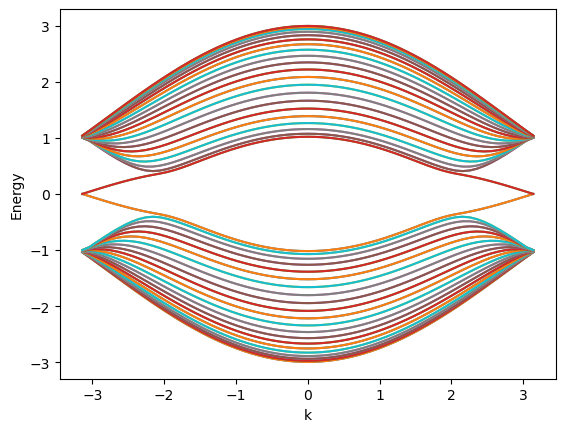

In [ ]:
kwant.plotter.bands(nano_ribbon2.finalized(), params=dict(param = SimpleNamespace(B = 0.0, t_prime=0.07, m=0.0)))
plt.show()

# Topological protection in ZTGQD

In [4]:
triangular_predot = create_graphene_tiangular_system(10, np.pi/2, 1.0, 2, 'zigzag')

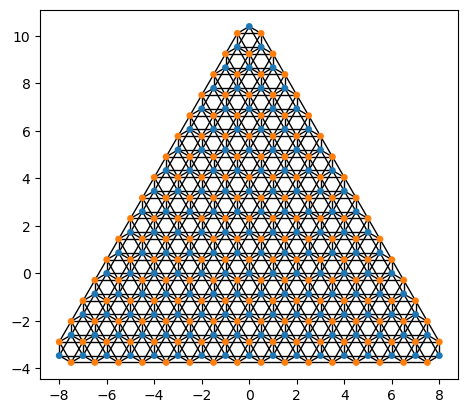

In [5]:
kwant.plot(triangular_predot)
plt.show()

In [ ]:
triangular_dot = triangular_predot.finalized()
h = triangular_dot.hamiltonian_submatrix(params=dict(param = SimpleNamespace(B=0.0, t_prime=0.05, m=0.0, U_imp=0.1, p=0.2)), sparse=True)
N = h.shape[0]

In [7]:
# square_lat = kwant.lattice.chain(a=1.0, norbs=2)
# lead1 = kwant.Builder(kwant.TranslationalSymmetry([1]))
# for j in range(6):
#     lead1[square_lat(j)] = 0*np.eye(2)
# lead1[square_lat.neighbors()] = -np.eye(2)
# kwant.plot(lead1)
# plt.show()
# sq_lat = kwant.lattice.chain(a=1.0, norbs=2)
# def site_color(site):
#     if site.tag == (-6, -4) and site.family == a_lat:
#         print(site.pos)
#         return 'red'  # highlight specific site
#     else:
#         return 'blue'  # default color for other sites

# # Define a one-site system
# one_site_system = kwant.Builder()
# one_site_system2 = kwant.Builder()
# one_site_system[list(lead1.sites())[0]] = 0  # Add a single site with onsite energy 0
# one_site_system2[list(lead1.sites())[0]] = 0  # Add a single site with onsite energy 0

# # Attach the lead to the one-site system
# one_site_system.attach_lead(lead1)
# one_site_system2.attach_lead(lead1)

# # Finalize the system
# # one_site_system = one_site_system.finalized()

# # Plot the system
# kwant.plot(one_site_system)
# plt.show()
# # Add hoppings from the one site to a site in the triangular_predot system
# site_to_connect = lat.a(-6, -4)  # Choose a site from triangular_predot
# site_to_connect2 = lat.a(10, -4)  # Choose a site from triangular_predot
# hopping_strength = -1 * sigma_0  # Define the hopping strength

# triangular_predot[list(one_site_system.sites())[0]] = 0*sigma_0
# triangular_predot[list(one_site_system2.sites())[0]] = 0*sigma_0
# # Add the hopping terms
# triangular_predot[list(one_site_system.sites())[0], site_to_connect] = nn_hopping
# triangular_predot[list(one_site_system2.sites())[0], site_to_connect2] = nn_hopping

# triangular_predot.attach_lead(lead1)
# triangular_predot.attach_lead(lead1.reversed())
# kwant.plot(triangular_predot)
# plt.show()
# triangular_predot.leads
# kwant.plotter.bands(triangular_predot.leads[-1].finalized(), params=dict(param = SimpleNamespace(B=0.0, t_prime=0.05, m=0.0, U_imp=0.1, p=0.2)))
# plt.show()
# lead = triangular_predot.leads[-1].finalized()
# bands = kwant.physics.Bands(lead)
# bands(0)